# example-load-podaac-S3-dataset

This notebook shows how to load a dataset from the PO.DAAC S3 data bucket on AWS West-2 while working from a JupyterHub environment also located on West-2. In our case, West-2 is the same cloud center as the SMCE JupyterHub, where the EIS Sea Level project does a lot of work. By reading data directly from the S3 bucket, so do not have to maintain our own copy, and should not need to pay extra to work with that data. This notebook is an attempt to show one way of working with that dataset. The notebook also includes nominal scripts for computing and plotting global fit functions to the example dataset, the JPL RL06 V2 GRACE(-FO) Mascon Solution.

As we improve our knowledge and integration with PO.DAAC S3 data, we will attempt to keep this notebook up to date to maintain a "best practice" example.

### Configuring Earthdata Authentication

You will need to setup Earthdata authentication to successfully use the PO.DAAC S3 bucket. A set of functions are included below to facilitate this (compiled from multiple sources, listed below). You can automate authentication by creating a ".netrc" file in your home directory and writing the following:

```
machine urs.earthdata.nasa.gov
    login <earthdata username>
    password <earthdata password>
```

On the SMCE JupyterHub, it is recommended that you do this from a terminal. First make sure you are in your home directory (`cd ~`), then create a new file and include the following:

```
cat >> .netrc
machine urs.earthdata.nasa.gov
    login <username>
    password <password>

```

Press `Enter` and then type `Ctrl+C` to save and close the prompt.

> **⚠️ Warning:** After writing the file, we _**strongly**_ recommend setting the new `.netrc` file to read-only for only the user using `chmod 0400 .netrc`. If you later need to edit this file, you can temporarily allow read/write by only the user with `chmod 0600 .netrc`. **NOTE:** Some SMCE users have found that they must reset the 0400 permissions every time they start a new SMCE server. If you find this to be the case, you can simply add the correct command to your bash profile or else run the first cell in this notebook. Alternatively, you may wish to forego using a .netrc file altogether and instead use the login prompt below to authenticate each time you use this notebook. _However, that prompt appears to be broken at this time..._

If configured successfully, you should see the following output from the second notebook cell.

```
# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.
```

Otherwise, you will see a message saying it could not use the .netrc file and it will ask you to input your username and password.

```
There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...
# Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.
Username: 
```

---

*Note: There is a pip package called "earthdata" that is supposed to help with this process, primarily in reducing code that we must write. However, I (Mike Croteau) have not been able to get it to install on the SMCE. I've tried cloning the default environment and installing this extra package with conda, as suggested by the earthdata devs, but I get unresolvable package inconsistencies. If anyone can get this working, please share.*

---

Sources:

- [Use Case: Study Amazon Estuaries with Data from the EOSDIS Cloud](https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Estuary_explore_inCloud_zarr.ipynb)
- [SWOT Oceanography with PO.DAAC](https://git.mysmce.com/eis-sealevel/swot/-/blob/main/tutorials/.ipynb_checkpoints/SWOT_simulated_L2_SSH_introduction-checkpoint.ipynb)
- ["Update cloud_direct_access_s3.py" - podaac tutorials commit 4da70c7cf079ddd7a6de4c4345749f580ba66d71](https://github.com/podaac/tutorials/commit/4da70c7cf079ddd7a6de4c4345749f580ba66d71#)

In [1]:
!chmod 0400 ~/.netrc

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

In [3]:
from urllib import request
from http.cookiejar import CookieJar
import netrc
import requests
import s3fs
import getpass

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.
    Valid endpoints:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
        print('# Your URS credentials were securely retrieved from your .netrc file.')
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print("There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...")
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass.getpass('Password: ')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
def begin_s3_direct_access():
    url="https://archive.podaac.earthdata.nasa.gov/s3credentials"
    r = requests.get(url)
    response = r.json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],secret=response['secretAccessKey'],token=response['sessionToken'],client_kwargs={'region_name':'us-west-2'})

edl = "urs.earthdata.nasa.gov"
setup_earthdata_login_auth(edl)
print('Earthdata login credentials configured. Ready.')

# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.


## Get data information from S3, then load the file you need.

Here, we initiate S3 access, then use s3fs to tell us what netcdf files are available in the given S3 bucket (printing out the last 5 for good measure). Then we select the last file and load it using xarray. Alternatively, you could attempt to use "harmony" to convert it to zarr format and load things from there (see the first source document above for more details).

In [10]:
# Initiate PO.DAAC S3 connection:
fs = begin_s3_direct_access()

# Get list of JPL mascon solutions:
s3_bucket = 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/*nc'
s3_files = fs.glob(s3_bucket)

# Print last 5 files:
s3_files[:5]

['podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r4_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-02_ECCO_V4r4_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-03_ECCO_V4r4_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-04_ECCO_V4r4_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-05_ECCO_V4r4_latlon_0p50deg.nc']

In [11]:
# Disko Bay
# UL: 69°17'41.9"N 53°05'39.0"W OR 69.294972 -53.094167
# LR: 68°45'42.8"N 51°23'32.7"W OR 68.761889 -51.392417
ul = [-53.1, 69.3]
lr = [-51.4, 68.7]

if False:
    # Local freezing point calculation
    a = -0.0575 # degC psu^-1
    b = 0.0901 # degC
    c = -7.61e-4 # degC dbar^-1

    T_f = a*S_B + b + c*p_B

In [19]:
# Read data
nc_file = s3_files[-1]

depths = None
lats = None
lons = None
theta_avg = None
salt_avg = None

with fs.open(nc_file, 'rb') as f:
    ds = xr.open_dataset(f, engine='h5netcdf')
    print(ds)
    
    depths = ds.Z.values
    lats = ds.latitude.values
    lons = ds.longitude.values
    
    theta = ds.THETA.values[0,:,:]
    salt = ds.SALT.values[0,:,:]
    # Average through depths
    z_idx = np.where( (depths <= -200) & (depths >= -400) )[0]
    lon_idx = np.where( (lons >= ul[0]) * (lons <= lr[0]) )[0]
    lon_min = lon_idx[0]; lon_max = lon_idx[-1]+1
    lat_idx = np.where( (lats <= ul[1]) * (lats >= lr[1]) )[0]
    lat_min = lat_idx[0]; lat_max = lat_idx[-1]+1
    theta_avg = np.mean(theta[z_idx,lat_min:lat_max,lon_min:lon_max], axis=0) #np.mean(ds.THETA.values[0,z_idx,:,:], axis=0)
    salt_avg = np.mean(salt[z_idx,lat_min:lat_max,lon_min:lon_max], axis=0) #np.mean(ds.SALT.values[0,z_idx,:,:], axis=0)
    
    ds.close()

<xarray.Dataset>
Dimensions:         (Z: 50, latitude: 360, longitude: 720, nv: 2, time: 1)
Coordinates:
  * time            (time) datetime64[ns] 2017-12-16T06:00:00
  * Z               (Z) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] ...
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...
    Z_bnds          (Z, nv) float32 ...
Dimensions without coordinates: nv
Data variables:
    THETA           (time, Z, latitude, longitude) float32 ...
    SALT            (time, Z, latitude, longitude) float32 ...
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fiel

In [36]:
print(z_idx)

theta[18,lat_min:lat_max,lon_min:lon_max]

print(depths[17])

[17 18 19 20]
-222.71


Text(0.5, 1.0, 'ocean potential temp. at depth -222.710007 m')

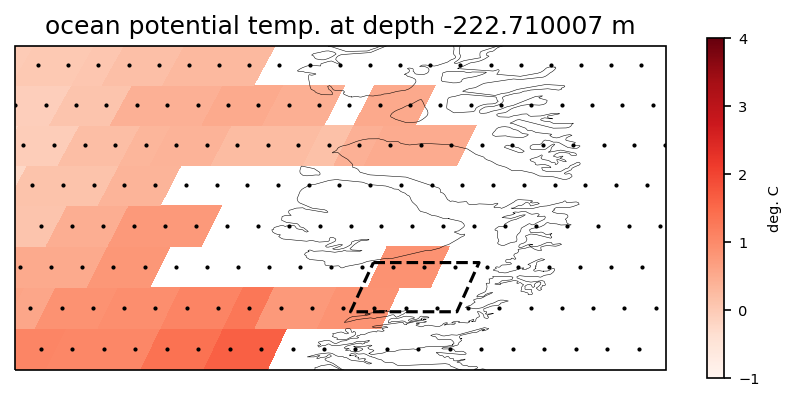

In [48]:
# Disko Bay
# UL: 69°17'41.9"N 53°05'39.0"W OR 69.294972 -53.094167
# LR: 68°45'42.8"N 51°23'32.7"W OR 68.761889 -51.392417
ul = [-53.1, 69.3]
lr = [-51.4, 68.7]

# Plot
fig = plt.figure(figsize=(7,3), dpi=150)
ax = plt.axes(projection=ccrs.Robinson(), extent=[-58, -50, 68, 72])

z_level = 17
pc = ax.pcolormesh(lons, lats, theta[z_level,:,:], cmap=plt.cm.Reds, transform=ccrs.PlateCarree(), vmin=-1, vmax=+4)
ax.plot([ul[0], lr[0], lr[0], ul[0], ul[0]], [ul[1], ul[1], lr[1], lr[1], ul[1]], 'k--', markersize=5, zorder=100, transform=ccrs.PlateCarree())

lonsm, latsm = np.meshgrid(lons,lats)
ax.plot(lonsm, latsm, 'k.', markersize=2, transform=ccrs.PlateCarree())

c = plt.colorbar(pc)
c.ax.tick_params(labelsize=7)
c.set_label('deg. C', size=7)

ax.coastlines(resolution='10m', zorder=7, linewidth=0.25)

ax.set_title('ocean potential temp. at depth {:f} m'.format(depths[z_level]))